<a href="https://colab.research.google.com/github/cmeyer555/cmeyer555.github.io/blob/main/CMPS_6160_M3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### HIV Prevalence: Trends and Predictors
By Christopher Meyer

[Project Webpage](cmeyer555.github.io)

## Project Goals
The purpose of this project is to determine the ways that social attitudes can predict access to care for HIV/AIDS (H/A) or the lack thereof. Also of import is trends in HIV/AIDS (H/A) diagnosis and care. H/A disproportionately affects LGBT people, and as such, there are often sociopolitical discourses that seek to stigmatize those suffering from H/A, leading to barriers to treatment. I will be using the CDCs data for H/A statistics throughout the country. Regarding social attitudes, I plan to use the General Society Survey from the University of Chicago.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


In [76]:
!git clone https://github.com/cmeyer555/cmeyer555.github.io.git
%cd cmeyer555.github.io/
!ls

Cloning into 'cmeyer555.github.io'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 62 (delta 24), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (62/62), 2.34 MiB | 9.57 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/cmeyer555.github.io/cmeyer555.github.io/cmeyer555.github.io
 6160_M2.html		  'CMPS6160_M1 (1).ipynb'   index.html
 AtlasPlusTableData.csv    CMPS_6160_M2.ipynb	   'Social Determinants.xlsx'
 AtlasPlusTableData.xlsx   GSS.xlsx


## Dataset 1
This dataset originates from the Centers for Disease Control and Prevention HIV data repository, which compiles official surveillance and survey data on HIV in the United States. It draws primarily from the National HIV Surveillance System- the primary source for monitoring HIV cases and trends in the U.S.. The inclusion of data from NHSS means the dataset is highly credible and widely used by public health officials and researchers to track the HIV epidemic. The CDC's role and the rigorous data collection processes (e.g. mandatory case reporting by states) ensure the data's authority and reliability for epidemiological analysis. With this dataset I can track H/A prevalence/diagnoses over time, as well as by region, which can then be compared with social attitudes in the same time period / geographic region.

In [ ]:
df = pd.read_excel("AtlasPlusTableData.xlsx", engine="openpyxl")

# Standardize column names
df.columns = df.columns.str.strip().str.capitalize().str.replace(" ", "_")

# Clean 'year' column
df["Year"] = df["Year"].astype(str).str.extract("(\d{4})").astype(int)

# Convert 'cases' to numeric + remove commas
df["Cases"] = pd.to_numeric(df["Cases"].astype(str).str.replace(",", ""), errors="coerce")

# Rename columns
df.rename(columns={"Rate_per_100000_(95%_ci)": "Rate_per_100k",
                  "Geography": "State"}, inplace=True)



This data is quite messy, with the thing being measured as its own column. Let's split the dataframe into several separate ones, separating the dataframe by the variable being measured, here designated in the "indicator" column

In [ ]:
indicator_values = df['Indicator'].unique()
indicator_dfs = {}

# Iterate through unique indicator values and create DataFrames
for indicator in indicator_values:
    indicator_dfs[indicator] = df[df['Indicator'] == indicator].copy()
    # We wont need the indicator column anymore, so that should be dropped
    indicator_dfs[indicator] = indicator_dfs[indicator].drop(columns=['Indicator'])

# Access individual DataFrames using the indicator value as the key

In [ ]:
indicator_dfs.keys() #Let's see what data we have available to us

dict_keys(['Receipt of HIV medical care', 'PrEP coverage and number of persons prescribed', 'HIV prevalence', 'AIDS prevalence', 'AIDS deaths', 'HIV Stigma', 'HIV deaths', 'HIV diagnoses', 'Linkage to HIV care', 'Unstable Housing or Homelessness'])

For now, I'm only interested in HIV diagnoses and prevalence rate

In [ ]:
hiv_diagnoses = indicator_dfs['HIV diagnoses']
hiv_prevalence = indicator_dfs['HIV prevalence']
PrEP_coverage = indicator_dfs['PrEP coverage and number of persons prescribed']
hiv_prevalence.head()

,Year,State,Fips,Cases,Rate_per_100k,Percent
2,2018,Alabama,1,13375.0,325.4,NaN
6,2019,Alabama,1,13765.0,333.4,NaN
10,2020,Alabama,1,14030.0,330.6,NaN
14,2021,Alabama,1,14336.0,335.9,NaN
18,2022,Alabama,1,14761.0,343.8,NaN


Now, using this tidy data, let's chart national HIV statistics over time

In [ ]:
# Group by year, sum the cases from each year
national_diagnoses = hiv_diagnoses.groupby("Year")["Cases"].sum().reset_index()
national_prevalence = hiv_prevalence.groupby("Year")["Cases"].sum().reset_index()

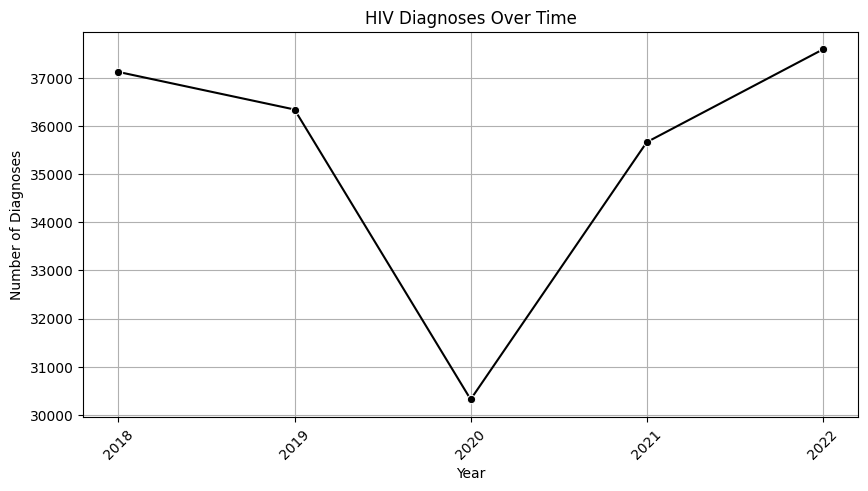

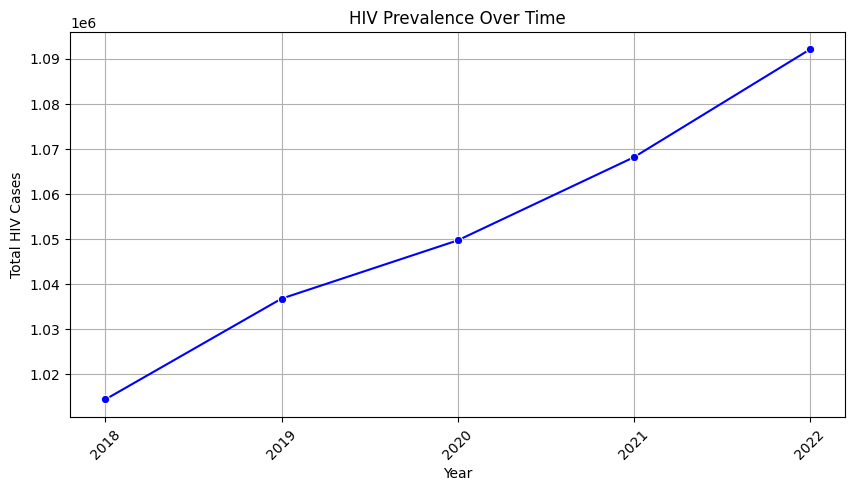

In [ ]:
# Plot 1: HIV Diagnoses Over Time
plt.figure(figsize=(10, 5))
sns.lineplot(data=national_diagnoses, x="Year", y="Cases", marker="o", color="black")
plt.title("HIV Diagnoses Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Diagnoses")
plt.xticks(national_diagnoses["Year"], rotation=45)
plt.grid(True)
plt.show()

# Plot 2: HIV Prevalence Over Time
plt.figure(figsize=(10, 5))
sns.lineplot(data=national_prevalence, x="Year", y="Cases", marker="o", color="blue")
plt.title("HIV Prevalence Over Time")
plt.xlabel("Year")
plt.ylabel("Total HIV Cases")
plt.xticks(national_prevalence["Year"], rotation=45)
plt.grid(True)
plt.show()

Yikes! looks like people weren't able to access STI testing due to COVID. We've already been able to identify a huge barrier to healthcare in this simple exploratory data analysis. Do HIV rates differ geographically? This is important as I'll be using state-level attitude data when synthesizing the HIV data with social data. Let's compare New York to Louisiana

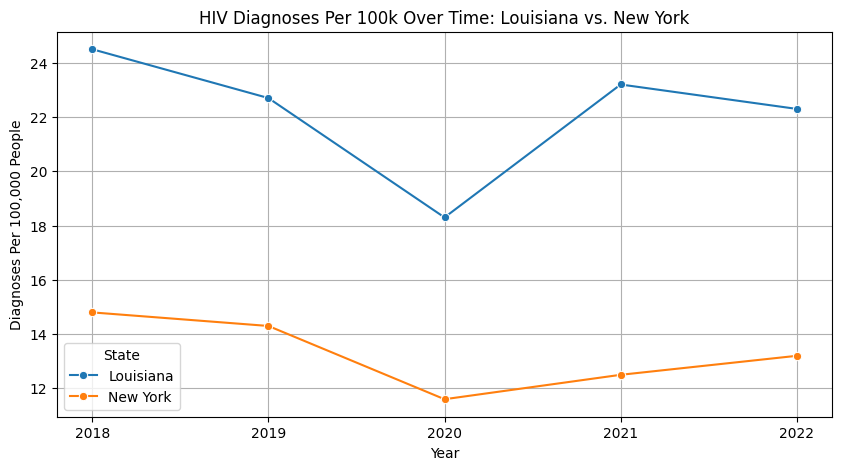

In [ ]:
selected_states = ["Louisiana", "New York"]

# Group by year and geography, using rate per 100k instead of total cases as the population sizes differ
state_trends = hiv_diagnoses.groupby(["Year", "State"])['Rate_per_100k'].mean().reset_index()

# Filter the data to include only selected states
filtered_state_trends = state_trends[state_trends['State'].isin(selected_states)]

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=filtered_state_trends, x="Year", y='Rate_per_100k', hue="State", marker="o")  # Pass 'rate_per_100k' as a string here as well

# Formatting
plt.title("HIV Diagnoses Per 100k Over Time: Louisiana vs. New York")
plt.xlabel("Year")
plt.ylabel("Diagnoses Per 100,000 People")
plt.legend(title="State")
plt.grid(True)
plt.xticks(ticks=filtered_state_trends["Year"].unique().astype(int))
plt.show()

There's a striking difference between Louisiana and New York in terms of diagnoses. This leads cleanly to further analyses: what differences between the states can explain such a wide gap?

## Dataset 2
The second dataset is from the the Human Rights Campaign. The HRC is a U.S. based non-profit advocacy group that has forwarded LGBT rights since 1980. Originally a PAC that distributed campaign funds to pro-LGBT congressional candidates. It has since rebranded as a general advocacy group that conducts research and educational seminars. Although they may be biased as they unabashedly promote queer rights, they are undoubtedly an expert on the subject of LGBT equality. Since 2004, they have published their state equality indices, reports evaluating each state on their LGBT policies. They now issue "scorecards" to each state, designating each state (and D.C.) on a scale of 1-4. Further information about decision criteria can be found [here.](https://www.hrc.org/resources/state-equality-index) Unfortunately they don't have a database of these evaluations, so I have to create it manually

In [ ]:
#Assign categories and state relations in a dictionary
groups_2018 = {
    "Working Toward Innovative Equality": [
        "California", "Colorado", "Connecticut", "Delaware","District of Columbia",
        "Illinois", "Maine", "Massachusetts","Minnesota", "Nevada", "New Jersey",
        "New York", "New Mexico", "Oregon", "Rhode Island", "Vermont",
        "Washington"],
    "Solidifying Equality": [
        "Hawaii", "Idaho", "Iowa", "Maryland", "New Hampshire"],
    "Building Equality": [
        "Utah", "Wisconsin"],
    "High Priority to Achieve Basic Equality": [
        "Alabama", "Alaska", "Arizona", "Arkansas", "Florida", "Georgia", "Indiana",
        "Kansas", "Kentucky", "Louisiana", "Michigan", "Mississippi", "Montanna",
        "Missouri", "Nebraska", "North Carolina", "North Dakota", "Ohio",
        "Oklahoma", "Pennsylvania", "South Carolina", "South Dakota", "Tennessee",
        "Texas", "Virginia", "West Virginia", "Wyoming" ]}

#Seperate out relations and create dataframe
sei_2018_data = [
    {"State": state, "Category": category}
    for category, states in groups_2018.items()
    for state in states]
sei_2018 = pd.DataFrame(sei_2018_data)

#Steps repeated above for 2019
groups_2019 = {
    "Working Toward Innovative Equality": [
        "California", "Colorado", "Connecticut", "Delaware", "District of Columbia",
        "Illinois", "Maine", "Maryland", "Massachusetts", "Minnesota", "Nevada",
        "New Jersey", "New Hampshire", "New Mexico", "New York", "Oregon",
        "Rhode Island", "Vermont", "Washington"],
    "Solidifying Equality": [
        "Hawaii", "Iowa"],
    "Building Equality": [
        "Utah", "Wisconsin"],
    "High Priority to Achieve Basic Equality": [
        "Alabama", "Alaska", "Arkansas", "Arizona", "Florida", "Georgia", "Idaho",
        "Indiana", "Kansas", "Kentucky", "Louisiana", "Michigan", "Mississippi",
        "Missouri", "Montana", "Nebraksa", "North Dakota", "Ohio", "Oklahoma",
        "North Carolina", "South Carolina", "Pennsylvania", "South Dakota",
        "Tennessee", "Texas", "Virginia","West Virginia", "Wyoming"]}

sei_2019_data = [
    {"State": state, "Category": category}
    for category, states in groups_2019.items()
    for state in states]
sei_2019 = pd.DataFrame(sei_2019_data)

#2020
groups_2020 = {
    "Working Toward Innovative Equality": [
        "California", "Colorado", "Connecticut", "Delaware", "District of Columbia",
        "Hawaii", "Illinois", "Maine", "Maryland", "Massachusetts", "Minnesota",
        "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York", "Oregon",
        "Rhode Island", "Vermont", "Washington"],
    "Solidifying Equality": [
        "Virginia", "Iowa"],
    "Building Equality": [
        "Kansas", "Pennsylvania", "Utah", "Wisconsin"],
    "High Priority to Achieve Basic Equality": [
        "Alabama", "Alaska", "Arizona", "Arkansas", "Florida", "Georgia", "Idaho",
        "Indiana", "Kentucky", "Louisiana", "Michigan", "Mississippi", "Missouri",
        "Montana", "Nebraska", "North Carolina", "North Dakota", "Ohio",
        "Oklahoma", "South Carolina", "South Dakota", "Tennessee", "Texas",
        "West Virginia", "Wyoming"]}

sei_2020_data = [
    {"State": state, "Category": category}
    for category, states in groups_2020.items()
    for state in states]
sei_2020 = pd.DataFrame(sei_2020_data)

#2021
groups_2021 = {
    "Working Toward Innovative Equality": [
        "California", "Colorado", "Connecticut", "Delaware", "District of Columbia",
        "Hawaii", "Illinois", "Iowa", "Maine", "Maryland", "Massachusetts",
        "Minnesota", "Nevada", "New Hampshire", "New Jersey", "New Mexico",
        "New York", "Oregon", "Rhode Island", "Vermont", "Virginia", "Washington"],
    "Solidifying Equality": [
        "Alaska", "Pennsylvania", "Utah"],
    "Building Equality": [
        "Florida", "Kansas", "North Dakota", "Wisconsin"],
    "High Priority to Achieve Basic Equality": [
        "Alabama", "Arizona", "Arkansas", "Georgia", "Idaho", "Indiana", "Kentucky",
        "Louisiana", "Michigan", "Mississippi", "Missouri", "Montana", "Nebraska",
        "North Carolina", "Ohio", "Oklahoma", "South Carolina", "South Dakota",
        "Tennessee", "Texas", "West Virginia", "Wyoming"]}

sei_2021_data = [
    {"State": state, "Category": category}
    for category, states in groups_2021.items()
    for state in states]
sei_2021 = pd.DataFrame(sei_2021_data)


# Grouped state categories for SEI 2022
groups_2022 = {
    "Working Toward Innovative Equality": [
        "California", "Colorado", "Connecticut", "Delaware", "District of Columbia",
        "Hawaii", "Illinois", "Maine", "Maryland", "Massachusetts", "Minnesota",
        "Nevada", "New Hampshire", "New Jersey", "New Mexico", "New York",
        "Oregon", "Rhode Island", "Vermont", "Virginia", "Washington"],
    "Solidifying Equality": [
        "Alaska", "Iowa", "Pennsylvania", "Utah", "Wisconsin"],
    "Building Equality": [
        "Kentucky", "North Dakota"],
    "High Priority to Achieve Basic Equality": [
        "Alabama", "Arizona", "Arkansas", "Florida", "Georgia", "Idaho", "Indiana",
        "Kansas", "Louisiana", "Michigan", "Mississippi", "Missouri", "Montana",
        "Nebraska", "North Carolina", "Ohio", "Oklahoma", "South Carolina",
        "South Dakota", "Tennessee", "Texas", "West Virginia", "Wyoming"]}

sei_2022_data = [
    {"State": state, "Category": category}
    for category, states in groups_2022.items()
    for state in states]

sei_2022 = pd.DataFrame(sei_2022_data)

sei_2022.head()

Now we need to join the dataframes together and clean the data

In [ ]:
# Add a year column to each SEI DataFrame
sei_2018["Year"] = 2018
sei_2019["Year"] = 2019
sei_2020["Year"] = 2020
sei_2021["Year"] = 2021
sei_2022["Year"] = 2022

# Combine all years into a single DataFrame
sei_df = pd.concat([
    sei_2018,
    sei_2019,
    sei_2020,
    sei_2021,
    sei_2022],
    ignore_index=True)

# Create ordinal scale for labels
category_to_score = {
    "Working Toward Innovative Equality": 1,
    "Solidifying Equality": 2,
    "Building Equality": 3,
    "High Priority to Achieve Basic Equality": 4}

sei_df["Score"] = sei_df["Category"].map(category_to_score)
sei_df.drop(columns=["Category"], inplace=True)

How progressive with respect to LGBT rights was the U.S. in 2022?

In [ ]:
sei_df[sei_df["Year"]==2022].Score.value_counts()

Still more states in the lowest category than the highest category :( Let's see if the U.S. has been getting more LGBT friendly with time.

In [ ]:
# Count states in each category per year
counts = sei_df.groupby(["Year", "Score"]).size().reset_index(name="Count")

# Calculate proportion per year
counts["Proportion"] = counts["Count"] / 51 #50 states + D.C.

# Categories -> cols.
proportion_df = counts.pivot(index="Year", columns="Score", values="Proportion")

# Reordering for graphic
proportion_df = proportion_df[[4, 3, 2, 1]]

# Plot
proportion_df.plot(kind="bar", stacked=True, figsize=(10, 6),
                   color = ["tomato", "peachpuff", "lightskyblue", "seagreen"])
plt.title("Proportion of States by SEI Category (2018–2022)")
plt.xlabel("Year")
plt.ylabel("Proportion of States")
plt.legend(title="SEI Category",
           labels=[
               "Few/No LGBT Rights",
               "Slight LGBT rights",
               "Moderate LGBT rights",
               "Strong LGBT rights"],
           bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()


Let's visualize how HIV diagnoses differs by SEI scores

In [ ]:
combined_hiv_diagnoses = pd.merge(
    hiv_diagnoses,
    sei_df,
    left_on=['State', 'Year'],
    right_on=['State', 'Year'],
    how='inner')

# Boxplot of HIV prevalence by equality category
plt.figure(figsize=(12, 6))
sns.boxplot(x='Score', y='Rate_per_100k', data= combined_hiv_diagnoses)
plt.title('HIV Diagnoses by State Equality Category')
plt.xlabel('HRC Equality Category')
plt.ylabel('HIV Rate per 100k')
plt.xticks(rotation=45, )
plt.tight_layout()
plt.show()

# Line plot showing trend of HIV prevalence by equality category over years
plt.figure(figsize=(12, 6))
category_means = combined_hiv_diagnoses.groupby(['Year', 'Score'])['Rate_per_100k'].mean().reset_index()
sns.lineplot(x='Year', y='Rate_per_100k', hue='Score', data=category_means)
plt.title('Trends in HIV Diagnoses by State Equality Category')
plt.ylabel('Average HIV Rate per 100k')
plt.tight_layout()
plt.show()

In [ ]:
combined_hiv_prevalence[combined_hiv_prevalence["Score"] == 1].sort_values(by="Rate_per_100k", ascending=False).head(10)


The visualizations don't seem to reveal anything interesting. What about health discrepencies? Do LGBT friendly states have higher access to HIV healthcare?

In [ ]:
hiv_care = indicator_dfs["Receipt of HIV medical care"]
care_gap = pd.merge(hiv_care, hiv_prevalence, on=["State", "Year"], suffixes=("_care", "_prev"))
care_gap["Gap"] = care_gap["Cases_care"] / care_gap["Cases_prev"]
care_gap = pd.merge(care_gap, sei_df[["State", "Year", "Score"]], on=["State", "Year"])
plt.figure(figsize=(12, 6))
sns.boxplot(x="Score", y="Gap", data=care_gap, hue="Score",palette="viridis")
plt.title("HIV Care Coverage by State Equality Category", fontsize=15)
plt.xlabel("HRC Equality Category", fontsize=12)
plt.ylabel("Percentage Receiving HIV Care", fontsize=12)
plt.xticks(rotation=45)
plt.show()


Unfortunately, looks like the SEI scores won't be very helpful in predicting HIV outcomes. Let's try other social data, also collected by the CDC

##Dataset 3
The third dataset i'll be using also comes from the CDC. The data is collected by the National Center for HIV, Viral Hepatitis, STD, and Tuberculosis Prevention, so refer to the Dataset 1 information

In [ ]:
soc_df = pd.read_excel("Social Determinants.xlsx")

# Standardize column names
soc_df.columns = soc_df.columns.str.strip().str.capitalize().str.replace(" ", "_")

# Clean 'year' column
soc_df["Year"] = soc_df["Year"].astype(str).str.extract("(\d{4})").astype(int)

# Convert 'cases' to numeric + remove commas
soc_df["Cases"] = pd.to_numeric(df["Cases"].astype(str).str.replace(",", ""), errors="coerce")

# Rename columns
soc_df.rename(columns={'Rate_per_100000_(95%_ci)': 'Rate_per_100k',
                  'Geography': 'State'}, inplace=True)

soc_indicator_values = soc_df['Indicator'].unique()
soc_indicators = {}

# Iterate through unique indicator values (variables) and create DataFrames
for indicator in soc_indicator_values:
    soc_indicators[indicator] = soc_df[soc_df['Indicator'] == indicator].copy()
    # We wont need the indicator column anymore, so that should be dropped
    soc_indicators[indicator] = soc_indicators[indicator].drop(columns=['Indicator'])
soc_indicators.keys() #Let's see what data we have available to us
uninsured_df = soc_indicators['Uninsured']
poverty_df = soc_indicators['Households living below the federal poverty level']
education_df = soc_indicators['Population 25 years and older w/o HS diploma']

Now that we have this new set of predictor variables, how do these social factors influence new HIV

In [ ]:
hiv_prevalence.drop(columns=["Percent"], inplace=True)

KeyError: "['Percent'] not found in axis"

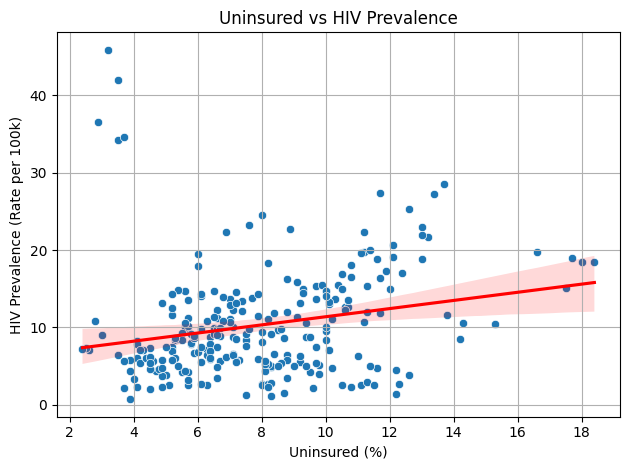

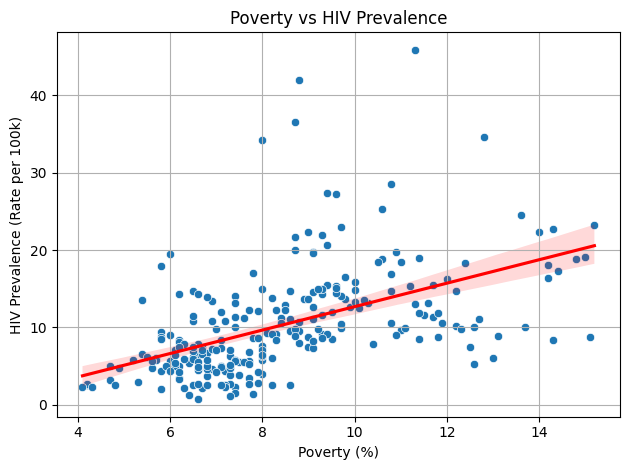

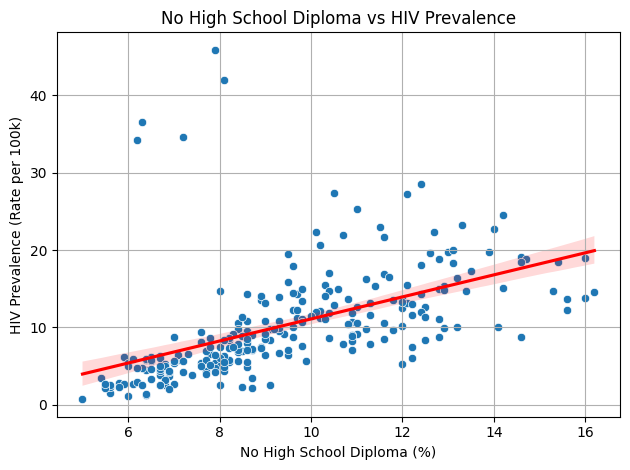

In [ ]:
hiv_df = indicator_dfs['HIV diagnoses'][['State', 'Year', 'Rate_per_100k']].copy()

# Dictionary of indicator labels and their DataFrames
social_data = {
    "Uninsured": uninsured_df,
    "Poverty": poverty_df,
    "No High School Diploma": education_df,}

for label, df in social_data.items():
    # Convert 'Percent' to numeric before merging
    df_copy = df.copy()
    # Merge with HIV data
    merged = pd.merge(df_copy[['State', 'Year', 'Percent']], hiv_df, on=['State', 'Year'])

    # Make sure Rate_per_100k is numeric
    merged['Rate_per_100k'] = pd.to_numeric(merged['Rate_per_100k'], errors='coerce')
    merged = merged.dropna()

    # Plot with regression line
    sns.scatterplot(data=merged, x='Percent', y='Rate_per_100k')
    sns.regplot(data=merged, x='Percent', y='Rate_per_100k', scatter=False, color='red')

    plt.title(f"{label} vs HIV Prevalence")
    plt.xlabel(f"{label} (%)")
    plt.ylabel("HIV Prevalence (Rate per 100k)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

There do seem to be slight relationships. How do they all contribute to predicting HIV prevalence?

In [ ]:
uninsured_df.rename(columns={'Percent': 'Percent_uninsured'}, inplace=True)
poverty_df.rename(columns={'Percent': 'Percent_poverty'}, inplace=True)
education_df.rename(columns={'Percent': 'Percent_noeducation'}, inplace=True)

In [ ]:
# First, let's create a combined dataset with all three social indicators
# Start by creating a copy of the HIV prevalence data
hiv_df = hiv_diagnoses[['State', 'Year', 'Rate_per_100k']].copy()
hiv_df['Rate_per_100k'] = hiv_df['Rate_per_100k'].astype(float)
# Add each social indicator
combined_df = pd.merge(hiv_df, uninsured_df, on=['State', 'Year'], how='left')
combined_df = pd.merge(combined_df, poverty_df, on=['State', 'Year'], how='left')
combined_df = pd.merge(combined_df, education_df, on=['State', 'Year'], how='left')

# Drop rows with missing values
combined_df = combined_df.dropna()

# Import statsmodels for regression analysis
import statsmodels.api as sm
from statsmodels.formula.api import ols

X = combined_df[["Percent_uninsured", "Percent_poverty", "Percent_noeducation"]]
X = sm.add_constant(X)
y = combined_df["Rate_per_100k"]

# Fit the multiple regression model
model = sm.OLS(y, X).fit()

# Display summary of the regression
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          Rate_per_100k   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.283
Method:                 Least Squares   F-statistic:                     15.47
Date:                Mon, 12 May 2025   Prob (F-statistic):           1.98e-08
Time:                        01:41:06   Log-Likelihood:                -360.55
No. Observations:                 111   AIC:                             729.1
Df Residuals:                     107   BIC:                             739.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -4.1589    

Well this model didn't perform spectacularly. Clearly the issue of HIV is very multifaceted. Let's visualize the performance by plotting predicted values vs. what the actual

In [ ]:
# Get predicted values
combined_df['predicted'] = model.predict(X)

# Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.scatter(combined_df['Rate_per_100k'], combined_df['predicted'], alpha=0.5)
plt.plot([combined_df['Rate_per_100k'].min(), combined_df['Rate_per_100k'].max()],
         [combined_df['Rate_per_100k'].min(), combined_df['Rate_per_100k'].max()])
plt.xlabel('Actual HIV Rate per 100k')
plt.ylabel('Predicted HIV Rate per 100k')
plt.title('Actual vs Predicted HIV Rates')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

Are there any noticable patterns in how the states are distributed along these variables that can elucidate why we're not noticing anything specific with our linear model?

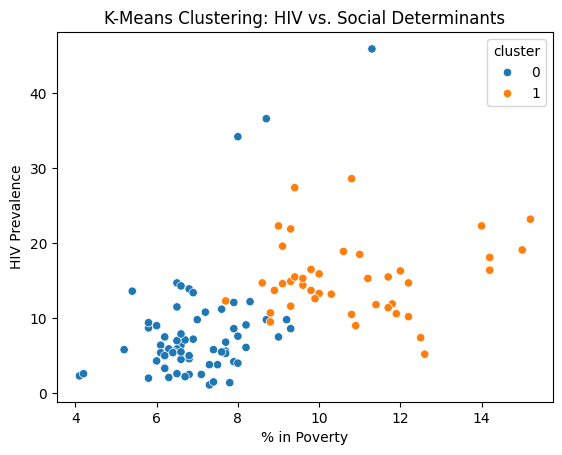

In [ ]:
features = combined_df[['Percent_noeducation', 'Percent_uninsured', 'Percent_poverty']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
combined_df['cluster'] = clusters

import matplotlib.pyplot as plt
import seaborn as sns

sns.scatterplot(data=combined_df,
                x='Percent_poverty',
                y='Rate_per_100k',
                hue='cluster',
                palette='tab10')
plt.title('K-Means Clustering: HIV vs. Social Determinants')
plt.xlabel('% in Poverty')
plt.ylabel('HIV Prevalence')
plt.show()


In [ ]:
from google.colab import files
files.download('CMPS_6160_M3.html')


FileNotFoundError: Cannot find file: CMPS_6160_M3.html

In [ ]:
!jupyter nbconvert --to html /content/cmeyer555.github.io/cmeyer555.github.io/CMPS_6160_M3.ipynb


[NbConvertApp] WARNING | pattern '/content/cmeyer555.github.io/cmeyer555.github.io/CMPS_6160_M3.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalen

In [ ]:
!git config --global user.email "cmeyer13@tulane.edu"
!git config --global user.name "Chris Meyer"

In [ ]:
!git add "CMPS_6160_M3.ipynb"

fatal: pathspec 'CMPS_6160_M3.ipynb' did not match any files


In [74]:
!ls

 6160_M2.html		  'CMPS6160_M1 (1).ipynb'   index.html
 AtlasPlusTableData.csv    CMPS_6160_M2.ipynb	   'Social Determinants.xlsx'
 AtlasPlusTableData.xlsx   GSS.xlsx


In [77]:
!cp CMPS_6160_M3.ipynb /content/cmeyer555.github.io/cmeyer555.github.io/

cp: cannot stat 'CMPS_6160_M3.ipynb': No such file or directory
